In [77]:
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [5]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [46]:
Bond_data = pd.read_pickle("reduced_data.pkl")

In [47]:
Bond_data.head()

Price    Volume  Trades    Return        Age  \
cusip     trd_dt                                                       
00817YAF5 2020-02-11  138.594       NaN     NaN       NaN  13.684932   
          2020-02-13  140.000 -0.358946     5.0  0.018426  13.690411   
          2020-02-19  138.763 -0.430609     2.0  0.006141  13.706849   
          2020-02-21  139.740 -0.457193     2.0  0.013541  13.712329   
          2020-02-25  138.656 -0.456037     2.0  0.008965  13.723288   

                            TTM  Stock_Return  Stock_Volume  ETF_Return  \
cusip     trd_dt                                                          
00817YAF5 2020-02-11  16.353425      0.008191      0.047574    0.003547   
          2020-02-13  16.347945     -0.023729      0.202542   -0.000321   
          2020-02-19  16.331507     -0.003056     -0.727394    0.007443   
          2020-02-21  16.326027     -0.005977     -0.638805   -0.009656   
          2020-02-25  16.315068     -0.052856      1.828526   -0.033927   

                            PV       YTM   Duration      DV01   Convexity  \
cusip     trd_dt                                                            
00817YAF5 2020-02-11 -0.003413  0.036039  11.719471 -1.624248  167.125039   
          2020-02-13  0.001198  0.035118  11.708106 -1.639135  166.882174   
          2020-02-19 -0.001111  0.035998  11.706361 -1.624410  166.782794   
          2020-02-21  0.006996  0.035361  11.730104 -1.639165  167.221531   
          2020-02-25  0.005850  0.036124  11.757090 -1.630191  167.700891   

                     RunningCoupon ParSpread CDSRealRecovery  \
cusip     trd_dt                                               
00817YAF5 2020-02-11          0.05  0.000729             0.4   
          2020-02-13          0.05  0.000756             0.4   
          2020-02-19          0.05  0.000721             0.4   
          2020-02-21          0.05  0.000739             0.4   
          2020-02-25          0.05  0.000829             0.4   

                     UpfrontBASpreadAverage ConvBASpreadAverage  \
cusip     trd_dt                                                  
00817YAF5 2020-02-11               0.008798             0.00109   
          2020-02-13               0.009437            0.001173   
          2020-02-19               0.009635            0.001197   
          2020-02-21               0.009693            0.001204   
          2020-02-25                0.01154            0.001435   

                     EstimatedNotional WklyNetNotional        DP   AA    A  \
cusip     trd_dt                                                             
00817YAF5 2020-02-11         5000000.0     222648000.0   0.06139  1.0  0.0   
          2020-02-13         5000000.0     222648000.0  0.061101  1.0  0.0   
          2020-02-19         5000000.0     222648000.0  0.059885  1.0  0.0   
          2020-02-21         5000000.0     222648000.0  0.060222  1.0  0.0   
          2020-02-25         5000000.0     222648000.0  0.065503  1.0  0.0   

                      BBB   BB    B  CCC  
cusip     trd_dt                          
00817YAF5 2020-02-11  0.0  0.0  0.0  0.0  
          2020-02-13  0.0  0.0  0.0  0.0  
          2020-02-19  0.0  0.0  0.0  0.0  
          2020-02-21  0.0  0.0  0.0  0.0  
          2020-02-25  0.0  0.0  0.0  0.0

In [48]:
len(Bond_data.index.get_level_values(0))

18258

In [49]:
unique_cusips = Bond_data.index.unique()
unique_cusip_count = unique_cusips.nunique()
unique_cusip_count

18258

In [50]:
Bond_data.columns

Index(['Price', 'Volume', 'Trades', 'Return', 'Age', 'TTM', 'Stock_Return',
       'Stock_Volume', 'ETF_Return', 'PV', 'YTM', 'Duration', 'DV01',
       'Convexity', 'RunningCoupon', 'ParSpread', 'CDSRealRecovery',
       'UpfrontBASpreadAverage', 'ConvBASpreadAverage', 'EstimatedNotional',
       'WklyNetNotional', 'DP', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC'],
      dtype='object')

In [51]:
def find_first_rating(row):
    rating_order = ['AA', 'A', 'BBB', 'BB', 'B', 'CCC']
    for rating in rating_order:
        if row[rating] == 1.0:
            return rating
    return None

Bond_data['Rating'] = Bond_data.apply(find_first_rating, axis=1)

grouped_ratings = Bond_data.groupby(Bond_data.index)['Rating'].first()

In [52]:
rating_percentage = grouped_ratings.value_counts(normalize=True) * 100
rating_percentage

A      44.006387
BBB    40.796212
AA     13.528991
BB      1.662904
B       0.005506
Name: Rating, dtype: float64

In [53]:
total_numbers = grouped_ratings.value_counts()
total_numbers

A      7992
BBB    7409
AA     2457
BB      302
B         1
Name: Rating, dtype: int64

In [54]:
def bond_price(coupon_rate, ytm, Years_Until_Maturity, risk_free_rate, AA,A,BBB,BB,B,CCC, face_value):
    if ytm <= risk_free_rate:
        return "Error: YTM must be greater than the risk-free rate."
    
    coupon_rate = 0 if coupon_rate is None else coupon_rate
    
    recovery_rate = 0.4208*AA + 0.3688*A + 0.329*BBB + 0.3451*BB + 0.3451*B + 0.3451*CCC
    
    default_probability = (ytm - risk_free_rate) /(1 - recovery_rate)  # placeholder here, may adjust how we calculate PD

    if default_probability < 0 or default_probability > 1:
        return "Error: Default probability out of bounds (0-1)."
    
    cash_flow_no_default = 0
    times = np.arange(0.5, Years_Until_Maturity, 0.5)
    semiannual_coupon_payment = face_value * (coupon_rate/ 2)
    cashflows = np.full(len(times), semiannual_coupon_payment)
    cashflows[-1] += face_value 
    for i in range(len(times)):
        cash_flow_no_default += cashflows[i] / np.power((1 + ytm/2), times[i])
        
    cash_flow_default = recovery_rate * face_value 

    # Calculating expected cash flow
    expected_cash_flow = ((1 - default_probability) * cash_flow_no_default) + (default_probability * cash_flow_default)

    # Discounting to present value
    return expected_cash_flow


In [55]:
def dcf(coupon_rate, ytm, Years_Until_Maturity, face_value):
    
    # Check if YTM is non-negative
    if ytm < 0:
        return "Error: YTM must be non-negative."
    
    coupon_rate = 0 if coupon_rate is None else coupon_rate

    cash_flow_total = 0
    times = np.arange(0.5, Years_Until_Maturity + 0.5, 0.5)  # Assuming semiannual coupons
    semiannual_coupon_payment = face_value * (coupon_rate/2)
    
    # Discount each cash flow back to the present value
    for time in times[:-1]:
        cash_flow_total += semiannual_coupon_payment / np.power((1 + ytm / 2), time)
    
    # Add the face value (discounted) for the last payment
    cash_flow_total += (face_value + semiannual_coupon_payment) / np.power((1 + ytm / 2), times[-1])

    return cash_flow_total

In [56]:
Bond_data['Calculated_Bond_Price_Rating'] = Bond_data.apply(
    lambda row: bond_price(
        row['RunningCoupon'], row['YTM'], row['TTM'], 
        risk_free_rate=0.02, 
        AA=row['AA'] if row['AA'] is not None else 0, 
        A=row['A'] if row['A'] is not None else 0, 
        BBB=row['BBB'] if row['BBB'] is not None else 0,
        BB=row['BB'] if row['BB'] is not None else 0,
        B=row['B'] if row['B'] is not None else 0,
        CCC=row['CCC'] if row['CCC'] is not None else 0,
        face_value=100
    ), axis=1)

In [57]:
Bond_data['dcf_price'] = Bond_data.apply(
    lambda row: dcf(
        row['RunningCoupon'], row['YTM'], row['TTM'], face_value=100
    ), axis=1)

In [58]:
Bond_data1 = Bond_data

In [59]:
numeric_columns = Bond_data1.select_dtypes(include=[np.number])
inf_mask = np.isinf(numeric_columns).any(axis=1)
rows_with_infinity = Bond_data1[inf_mask]

print(rows_with_infinity)

Empty DataFrame
Columns: [Price, Volume, Trades, Return, Age, TTM, Stock_Return, Stock_Volume, ETF_Return, PV, YTM, Duration, DV01, Convexity, RunningCoupon, ParSpread, CDSRealRecovery, UpfrontBASpreadAverage, ConvBASpreadAverage, EstimatedNotional, WklyNetNotional, DP, AA, A, BBB, BB, B, CCC, Rating, Calculated_Bond_Price_Rating, dcf_price]
Index: []


In [60]:
Bond_data2 = Bond_data1.dropna(subset=['Price', 'Calculated_Bond_Price_Rating'])
Bond_data2 = Bond_data2[Bond_data2['Calculated_Bond_Price_Rating'] != 'Error: YTM must be greater than the risk-free rate.']
Bond_data2 = Bond_data2[Bond_data2['Calculated_Bond_Price_Rating'] != 'Error: Default probability out of bounds (0-1).']

mse = mean_squared_error(Bond_data2["Price"], Bond_data2["Calculated_Bond_Price_Rating"])
rmse = mean_squared_error(Bond_data2["Price"], Bond_data2["Calculated_Bond_Price_Rating"], squared=False)
mae = mean_absolute_error(Bond_data2["Price"], Bond_data2["Calculated_Bond_Price_Rating"])

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)


MSE: 3.100243972328572
RMSE: 1.7607509682884097
MAE: 1.5365404061417147


In [63]:
rows_with_large_diff = Bond_data2[abs(Bond_data2['Calculated_Bond_Price_Rating'] - Bond_data2['Price']) > 0.5]
rows_with_large_diff.shape

(15538, 31)

In [66]:
mse = mean_squared_error(rows_with_large_diff["Price"], rows_with_large_diff["dcf_price"])
rmse = mean_squared_error(rows_with_large_diff["Price"], rows_with_large_diff["dcf_price"], squared=False)
mae = mean_absolute_error(rows_with_large_diff["Price"], rows_with_large_diff["dcf_price"])

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 22.868477186890214
RMSE: 4.782099663002667
MAE: 4.313582513003797


In [71]:
cusip_set = Bond_data2[['Price','Calculated_Bond_Price_Rating', 'dcf_price']]

In [72]:
cusip_set = final_set.rename(columns={
    'Price': 'market_price',
    'Calculated_Bond_Price_Rating': 'reduced_form_price',
    'dcf_price': 'dcf_price'
})

In [75]:
cusip_set.head()

market_price  reduced_form_price   dcf_price
cusip     trd_dt                                                  
00817YAF5 2020-02-11       138.594          141.586190  145.614119
          2020-02-13       140.000          142.522187  146.434066
          2020-02-19       138.763          141.628041  145.650804
          2020-02-21       139.740          142.273990  146.216747
          2020-02-25       138.656          141.500167  145.538708

In [74]:
index_with_most_rows = cusip_set.index.value_counts().idxmax()
index_with_most_rows

('00817YAF5', Timestamp('2020-02-11 00:00:00'))

In [76]:
index_exists = '00817YAF5' in cusip_set.index
index_exists

True

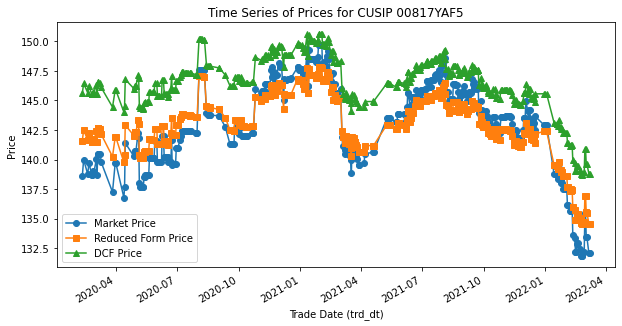

In [83]:
cusip_set = cusip_set.reset_index()
cusip_set['trd_dt'] = pd.to_datetime(cusip_set['trd_dt'])
cusip_set = cusip_set.set_index(['cusip', 'trd_dt'])
plt.figure(figsize=(10, 5))

plt.plot(cusip_set.loc['00817YAF5'].index.get_level_values('trd_dt'), cusip_set.loc['00817YAF5']['market_price'], label='Market Price', marker='o')
plt.plot(cusip_set.loc['00817YAF5'].index.get_level_values('trd_dt'), cusip_set.loc['00817YAF5']['reduced_form_price'], label='Reduced Form Price', marker='s')
plt.plot(cusip_set.loc['00817YAF5'].index.get_level_values('trd_dt'), cusip_set.loc['00817YAF5']['dcf_price'], label='DCF Price', marker='^')

plt.title('Time Series of Prices for CUSIP 00817YAF5')
plt.xlabel('Trade Date (trd_dt)')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()